In [ ]:
import google.generativeai as genai
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv('../.env')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import requests
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import tiktoken

genai.configure(api_key=os.environ['GEMINI_KEY'])
model = genai.GenerativeModel("gemini-1.5-flash")

In [21]:
# Exercicio 4
url = "https://g1.globo.com/"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

headlines = [headline.text.strip() for headline in soup.find_all(['h2', 'h3'])]

prompt = f"""
Dada uma manchete de notícia, categorize-a em uma das três categorias: 'Positiva', 'Neutra' ou 'Negativa'.
Aqui estão alguns exemplos:

1. "Economia do Brasil cresce 2% no último trimestre" - Positiva
2. "Temperaturas caem abaixo de zero no sul do país" - Neutra
3. "Aumento da violência assusta moradores de São Paulo" - Negativa

Agora, classifique as seguintes manchetes:

{headlines}

Estruture o resultado em JSON no seguinte formato:
{{
  "Positiva": ["manchete 1", "manchete 2"],
  "Neutra": ["manchete 3"],
  "Negativa": ["manchete 4", "manchete 5"]
}}

Quero um codigo python **válido e sem explicações extras** que salva o resultado em 'data/noticias.json'
"""

response = model.generate_content(prompt)
analysis_code = response.text.replace("```python\n", "").replace("\n```", "")
exec(analysis_code)

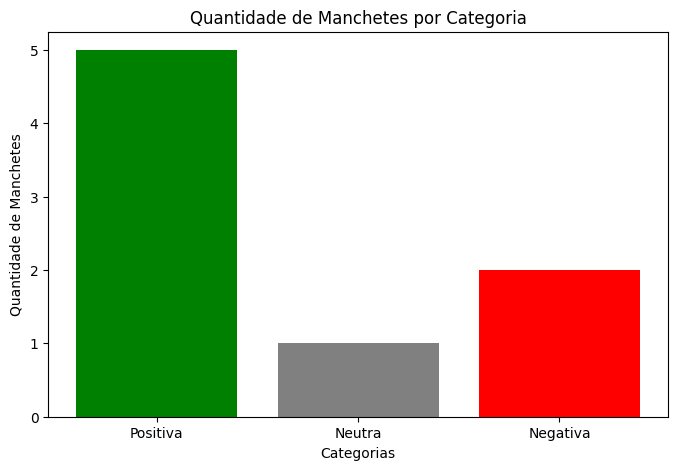

In [22]:
with open('data/noticias.json', 'r', encoding='utf-8') as file:
    noticias = json.load(file)
categorias = ['Positiva', 'Neutra', 'Negativa']
quantidades = [len(noticias[categoria]) for categoria in categorias]
plt.figure(figsize=(8, 5))
plt.bar(categorias, quantidades, color=['green', 'gray', 'red'])
plt.title('Quantidade de Manchetes por Categoria')
plt.xlabel('Categorias')
plt.ylabel('Quantidade de Manchetes')

plt.show()

In [4]:
# Exercicio 5
df_script = pd.read_csv('../simpsons_data/simpsons_script_lines.csv', low_memory=False)
df_episodes = pd.read_csv('../simpsons_data/simpsons_episodes.csv', low_memory=False)
df_characters = pd.read_csv('../simpsons_data/simpsons_characters.csv', low_memory=False)
df_locations = pd.read_csv('../simpsons_data/simpsons_locations.csv', low_memory=False)

df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)

assert data.shape[0] == df_script.shape[0]

In [12]:
data.columns

Index(['episode_id', 'number', 'raw_text', 'timestamp_in_ms', 'speaking_line',
       'character_id', 'location_id', 'raw_character_text',
       'raw_location_text', 'spoken_words', 'normalized_text', 'word_count',
       'episode_image_url', 'episode_imdb_rating', 'episode_imdb_votes',
       'episode_number_in_season', 'episode_number_in_series',
       'episode_original_air_date', 'episode_original_air_year',
       'episode_production_code', 'episode_season', 'episode_title',
       'episode_us_viewers_in_millions', 'episode_video_url', 'episode_views',
       'character_name', 'character_normalized_name', 'character_gender',
       'location_name', 'location_normalized_name', 'token_count'],
      dtype='object')

In [8]:
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text):
    if pd.isna(text):
        return 0
    return len(enc.encode(text))

data['token_count'] = data['spoken_words'].apply(count_tokens)

tokens_per_episode = data.groupby('episode_id')['token_count'].sum().reset_index()
tokens_per_episode = tokens_per_episode.merge(df_episodes, on='episode_id')

tokens_per_season = tokens_per_episode.groupby('episode_season')['token_count'].mean().reset_index()

max_tokens_episode = tokens_per_episode.loc[tokens_per_episode['token_count'].idxmax()]
max_tokens_season = tokens_per_season.loc[tokens_per_season['token_count'].idxmax()]

print("Média de tokens por episódio:", tokens_per_episode['token_count'].mean())
print("Média de tokens por temporada:", tokens_per_season['token_count'].mean())
print("Episódio com mais tokens:", max_tokens_episode)
print("Temporada com mais tokens:", max_tokens_season)

Média de tokens por episódio: 3317.909574468085
Média de tokens por temporada: 3312.910147516114
Episódio com mais tokens: episode_id                                                                       28
token_count                                                                    4312
episode_image_url                 http://static-media.fxx.com/img/FX_Networks_-_...
episode_imdb_rating                                                             8.2
episode_imdb_votes                                                           1413.0
episode_number_in_season                                                         15
episode_number_in_series                                                         28
episode_original_air_date                                                1991-02-21
episode_original_air_year                                                      1991
episode_production_code                                                        7F16
episode_season                       

In [31]:
# Exercicio 6
positivas = [
   "I love donuts! They make me happy!"
   "That's amazing! You did a great job!"
   "The whole family together? This is the best day ever!",
   "I received a wonderful gift, I'm very happy.",
   "Today the sun is beautiful and everything seems perfect."
]
negativas = [
   "That was the worst thing that ever happened to me!"
   "I'm so tired I can barely stand up.",
   "I can't believe I lost that game, it was horrible.",
   "You always ruin everything, you can't do it anymore!",
   "Today nothing went right, it was a terrible day."
]
neutras = [
   "I need to go to the market to buy milk.",
   "Yesterday it rained a lot, but today it's normal.",
   "I'm going to make dinner at 8 pm.",
   "It's okay, just an ordinary day.",
   "Marge asked me to fix the faucet."
]

episode_season = 5
episode_id = 92
X = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)
X = X.dropna(subset='normalized_text')

prompt = f"""
You are an expert in human communications and marketing, specializing in sentiment analysis.
You must classify a cartoon's lines as negative, neutral and positive, as defined below:
- positive: happy, constructive, hopeful, joyful lines and the like.
- negative: sad, destructive, hopeless, aggressive and similar speeches.
- neutral: indifferent, objective, formal and close lines such as positive or negative.

Some pre-rated lines from this program are included here:

# Positiva:
{ '- '.join(positivas) }


# Negativa:
{ '- '.join(negativas) }


# Neutro:
{ '- '.join(neutras) }

Diante dessas informações, responda em JSON com a classificação dessas outras linhas como positivas, negativas ou neutras.

{ '- '.join(X.normalized_text.tolist()[:100]) }

"""
response = model.generate_content(prompt)
print(response.text)

```json
{
  "lines": [
    {
      "line": "dad weve been robbed",
      "sentiment": "negative"
    },
    {
      "line": "wake up dad wake up there was a burglar and he took my saxophone",
      "sentiment": "negative"
    },
    {
      "line": "woo hoo",
      "sentiment": "positive"
    },
    {
      "line": "and our portable tv",
      "sentiment": "negative"
    },
    {
      "line": "and my necklace",
      "sentiment": "negative"
    },
    {
      "line": "eh thats no big loss",
      "sentiment": "neutral"
    },
    {
      "line": "homer that necklace was a priceless bouvier family heirloom",
      "sentiment": "negative"
    },
    {
      "line": "oh youve probably got a whole drawer full of em",
      "sentiment": "neutral"
    },
    {
      "line": "well yes i do but theyre all heirlooms too",
      "sentiment": "neutral"
    },
    {
      "line": "the burglar even took my stamp collection",
      "sentiment": "negative"
    },
    {
      "line": "you had a stamp

In [18]:
# Exercicio 7
def quantidade_tokens(text):
    if pd.isna(text):
        return 0
    return len(enc.encode(text))

episode_data = data[(data['episode_id'] == episode_id) & (data['episode_season'] == episode_season)]

episode_lines = episode_data['raw_text'].dropna().tolist()
episode_summary = " ".join(episode_lines)

tokens = quantidade_tokens(episode_summary)

print(f"Resumo do Episódio 'Homer, o Vigilante' (Episódio {episode_id}, Temporada {episode_season}):")
print(episode_summary[:500])
print(f"\nContagem de tokens: {tokens}")

Resumo do Episódio 'Homer, o Vigilante' (Episódio 92, Temporada 5):
Homer Simpson: (ABSENTLY) Can't talk. Robbed. Go hell. (Simpson Home: Ext. Simpson House - night - establishing) Bart Simpson: Dad! We've been robbed! Lisa Simpson: (SHAKING HIM) Wake up, Dad! Wake up! There was a burglar and he took my saxophone. Homer Simpson: Woo hoo! Bart Simpson: And our portable TV! Homer Simpson: (ANNOYED GRUNT) Marge Simpson: And my necklace. Homer Simpson: Eh, that's no big loss. Marge Simpson: Homer! That necklace was a priceless Bouvier family heirloom. Homer Simpson:

Contagem de tokens: 5149


In [ ]:
# Exercicio 8
def create_chunks(lines, chunk_size=100, overlap=25):
    chunks = []
    for i in range(0, len(lines), chunk_size - overlap):
        chunk = lines[i:i + chunk_size]
        chunks.append(" ".join(chunk))
        if len(chunk) < chunk_size:
            break
    return chunks
chunks = create_chunks(episode_lines)
print(f"Total de chunks criados: {len(chunks)}")

def summarize_chunk(chunk):
    prompt = f"Resuma o seguinte trecho do episódio das Simpsons: {chunk}"
    response = model.generate_content(prompt)
    return response.text 
chunk_summaries = [summarize_chunk(chunk) for chunk in chunks]
print(f"Resumo do primeiro chunk: {chunk_summaries[0]}")

final_summary_prompt = "Você recebeu resumos dos seguintes trechos do episódio número 92, temporada 5 de Simpsons:\n"

for i, summary in enumerate(chunk_summaries, 1):
    final_summary_prompt += f"{i}. {summary}\n"
final_summary_prompt += "Com base nos resumos acima, escreva um resumo final para o episódio, incluindo a explicação geral dos eventos e o desfecho do episódio."
final_summary = model.generate_content(final_summary_prompt)
print(f"Resumo final do episódio: {final_summary.text}")

Total de chunks criados: 4
Resumo do primeiro chunk: Os Simpsons são vítimas de um roubo cometido pelo "Ladrão de Gatos de Springfield".  O ladrão leva a coleção de selos de Bart, o saxofone de Lisa, o colar de família de Marge e outros pertences dos vizinhos, incluindo as toalhas de praia de Ned Flanders e os pratos comemorativos do Diretor Skinner.  A polícia, liderada pelo incompetente Chefe Wiggum, é ineficaz na investigação.  Homer, inicialmente indiferente, decide recuperar o saxofone de Lisa.  Após uma demonstração de um sistema de segurança de alta tecnologia (e um incidente com um laser),  uma patrulha improvisada da vizinhança, liderada por Homer, é formada para capturar o ladrão.

Resumo final do episódio: O episódio começa com uma onda de roubos em Springfield, incluindo a coleção de selos de Bart, o saxofone de Lisa e o colar de Marge.  A ineficiência da polícia leva Homer a formar uma patrulha de vigilância improvisada, composta por moradores de Springfield, incluindo Moe

In [ ]:
# Exercicio 10

positivas = [
   "I love donuts! They make me happy!"
   "That's amazing! You did a great job!"
   "The whole family together? This is the best day ever!",
   "I received a wonderful gift, I'm very happy.",
   "Today the sun is beautiful and everything seems perfect."
]
negativas = [
   "That was the worst thing that ever happened to me!"
   "I'm so tired I can barely stand up.",
   "I can't believe I lost that game, it was horrible.",
   "You always ruin everything, you can't do it anymore!",
   "Today nothing went right, it was a terrible day."
]
neutras = [
   "I need to go to the market to buy milk.",
   "Yesterday it rained a lot, but today it's normal.",
   "I'm going to make dinner at 8 pm.",
   "It's okay, just an ordinary day.",
   "Marge asked me to fix the faucet."
]

episode_season = 5
episode_id = 92
X = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)
X = X.dropna(subset='normalized_text')

prompt = f"""
You are an expert in human communications and marketing, specializing in sentiment analysis.
You must classify a cartoon's lines as negative, neutral and positive, as defined below:
- positive: happy, constructive, hopeful, joyful lines and the like.
- negative: sad, destructive, hopeless, aggressive and similar speeches.
- neutral: indifferent, objective, formal and close lines such as positive or negative.

Some pre-rated lines from this program are included here:

# Positiva:
{ '- '.join(positivas) }


# Negativa:
{ '- '.join(negativas) }


# Neutro:
{ '- '.join(neutras) }

Diante dessas informações, salve em um arquivo '../data/sentimento.csv.

{ '- '.join(X.normalized_text.tolist()[:100]) }

"""
response = model.generate_content(prompt)
analysis_code = response.text.replace("```python\n", "").replace("\n```", "")
exec(analysis_code)

CSV file '../data/sentimento.csv' created successfully.


In [38]:
prompt_1 = """
Tenho um arquivo '../data/sentimentos.csv' com as features(line,sentiment). Faça a leitura e preparação dos dados do arquivo CSV, garantindo que as colunas "line" e "sentiment" sejam adequadas para análise.
"""
response = model.generate_content(prompt_1)
print(response.text)

Este código lê o arquivo CSV `sentimentos.csv`, limpa os dados e prepara as colunas "line" e "sentiment" para análise. Ele lida com possíveis erros de codificação e valores ausentes.  O código assume que "sentiment" contém rótulos de sentimento categóricos.  Se for numérico, a adaptação é simples.

```python
import pandas as pd

def preparar_dados(caminho_arquivo):
    """
    Lê, limpa e prepara os dados do arquivo CSV.

    Args:
        caminho_arquivo: Caminho para o arquivo CSV.

    Returns:
        Um DataFrame pandas com as colunas "line" e "sentiment" preparadas, 
        ou None se houver um erro durante a leitura ou processamento.
    """
    try:
        # Lê o arquivo CSV, tratando possíveis erros de codificação
        df = pd.read_csv(caminho_arquivo, encoding='utf-8', engine='python', on_bad_lines='skip')


        # Remove linhas com valores ausentes nas colunas relevantes
        df.dropna(subset=['line', 'sentiment'], inplace=True)

        # Remove espaços em branco

In [39]:
prompt_2 = f"""
Tenho um df com as features(line,sentiment). Agora faça a leitura do resultado da análise de sentimento e faça um gráfico de pizza mostrando a proporção de falas de categoria do episódio.
"""
response = model.generate_content(prompt_2)
print(response.text)

Para criar um gráfico de pizza mostrando a proporção de sentimentos em seu DataFrame, você precisará usar bibliotecas como Pandas e Matplotlib (ou Seaborn para um visual mais sofisticado).  Assumindo que seu DataFrame se chama `df` e possui colunas 'line' (a fala) e 'sentiment' (o sentimento classificado, e.g., 'positivo', 'negativo', 'neutro'), o código abaixo faz o trabalho:


```python
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que seu DataFrame seja chamado 'df' e tenha colunas 'line' e 'sentiment'
# Substitua 'seu_arquivo.csv' pelo nome do seu arquivo CSV

# df = pd.read_csv('seu_arquivo.csv')


# Contagem de sentimentos
sentiment_counts = df['sentiment'].value_counts()

# Criando o gráfico de pizza
plt.figure(figsize=(8, 8))  # Ajusta o tamanho do gráfico
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proporção de Sentimentos')
plt.axis('equal')  # Garante que o gráfico seja um círculo
plt.show()


```

*

In [51]:
prompt_3 = f"""
Development of the Streamlit application, allowing CSV file upload and interactive data visualization and pie charts. Knowing that the csv has the features(line,sentiment)
I want python code **valid and without extra explanations**
"""
response = model.generate_content(prompt_3)
print(response.text)

```python
import streamlit as st
import pandas as pd
import plotly.express as px

st.title("CSV Data Visualizer")

uploaded_file = st.file_uploader("Choose a CSV file", type="csv")

if uploaded_file is not None:
    data = pd.read_csv(uploaded_file)
    st.dataframe(data)

    sentiment_counts = data['sentiment'].value_counts()
    fig_pie = px.pie(names=sentiment_counts.index, values=sentiment_counts.values, title='Sentiment Distribution')
    st.plotly_chart(fig_pie)

    fig_line = px.line(data, x='line', y='sentiment', title='Sentiment over Lines')
    st.plotly_chart(fig_line)

```



In [53]:
codelines = response.text.replace("```python\n",'').replace("\n```",'')
with open('dashboard.py','w') as fid:
    fid.write(codelines)